# Import

In [1]:
import sys
from pathlib import Path

# Definition du chemin vers notre code source local
sys.path.append(str(Path().resolve().parent.parent))

In [ ]:
from stravalib import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from src.gap.data_preprocessing import (
    get_activity_streams, 
    process_streams, 
    prepare_ml_calibration_dataset,
    process_single_stream
)
from src.gap.modeling import (
    calculate_normalized_efficiency,
    calculate_efficiency_model_gap,
    fit_gap_model,
    get_efficiency_model_gap_curve,
    get_xgboost_gap_curve,
    plot_gap_curves
)

# Define

In [5]:
VERBOSE = True
SPORT_TYPES = ["TrailRun"]

# Activate API (`ONLY RUN THIS SECTION ONCE`)

In [6]:
client = Client()
url = client.authorization_url(
    client_id=157889,
    redirect_uri="http://localhost:5000/authorization",
)

if VERBOSE:
    print("Paste this URL on web browser and copy the string after 'code=...'")
    print(url)

Paste this URL on web browser and copy the string after 'code=...'
https://www.strava.com/oauth/authorize?client_id=157889&redirect_uri=http%3A%2F%2Flocalhost%3A5000%2Fauthorization&approval_prompt=auto&scope=read%2Cactivity%3Aread&response_type=code


In [7]:
token_response = client.exchange_code_for_token(
    client_id=157889, client_secret="c706246b4920e85a8244a26b5e1324d95f787bce", code="83acb66e219b11f1f37aa5a739415e6672091c46" #COPY PASTED CODE HERE
)

STORED_ACCESS_TOKEN = token_response["access_token"]
STORED_REFRESH_TOKEN = token_response["refresh_token"]  # You will need this in 6 hours if you want to stay connected

# Full Data download and pre-processing

In [8]:
# Collect all running activity ids
client = Client(access_token=STORED_ACCESS_TOKEN)
all_activities = client.get_activities()

selected_activities = []
sport_types = []
for act in all_activities:
    if act.has_heartrate and act.sport_type.root in SPORT_TYPES:
        selected_activities.append(act)
        sport_types.append(act.sport_type.root)

In [9]:
# Download all activity streams
streams = get_activity_streams(client, selected_activities, max_streams=1000)

In [10]:
# Pre-process all activity streams
speed, elevation_gain, heartrate, sport_types = process_streams(streams, sport_types[:len(streams)], split_min_time=10)


Processing streams for activity 1/61
Successfully processed streams

Processing streams for activity 2/61
Successfully processed streams

Processing streams for activity 3/61
Successfully processed streams

Processing streams for activity 4/61
Successfully processed streams

Processing streams for activity 5/61
Successfully processed streams

Processing streams for activity 6/61
Successfully processed streams

Processing streams for activity 7/61
Successfully processed streams

Processing streams for activity 8/61
Successfully processed streams

Processing streams for activity 9/61
Successfully processed streams

Processing streams for activity 10/61
Successfully processed streams

Processing streams for activity 11/61
Successfully processed streams

Processing streams for activity 12/61
Successfully processed streams

Processing streams for activity 13/61
Successfully processed streams

Processing streams for activity 14/61
Successfully processed streams

Processing streams for activ

# Visualize the data

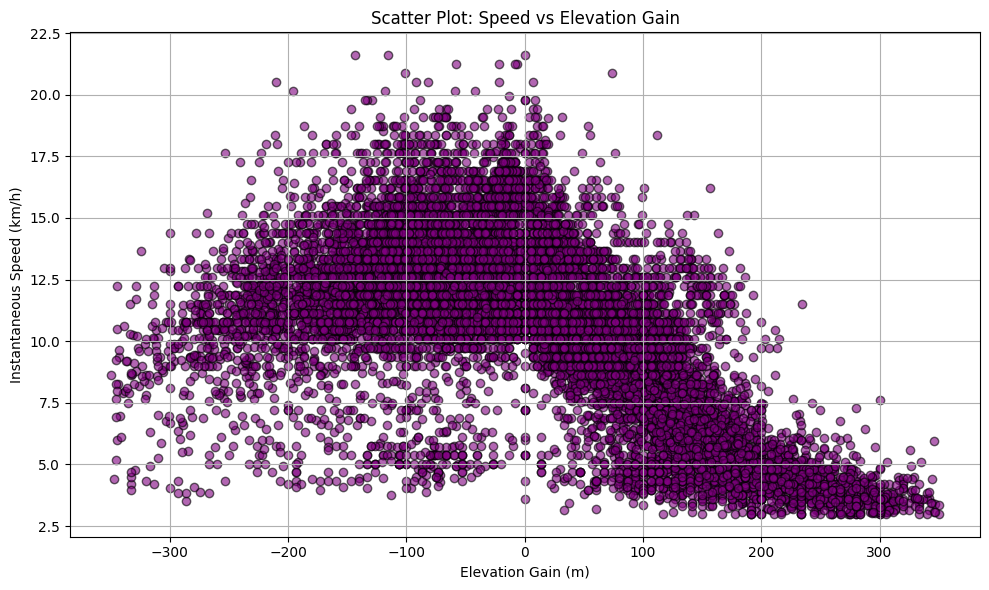

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(elevation_gain, speed, alpha=0.6, color='purple', edgecolor='k')
plt.xlabel("Elevation Gain (m)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Scatter Plot: Speed vs Elevation Gain")
plt.grid(True)
plt.tight_layout()

if VERBOSE:
    fig.show()

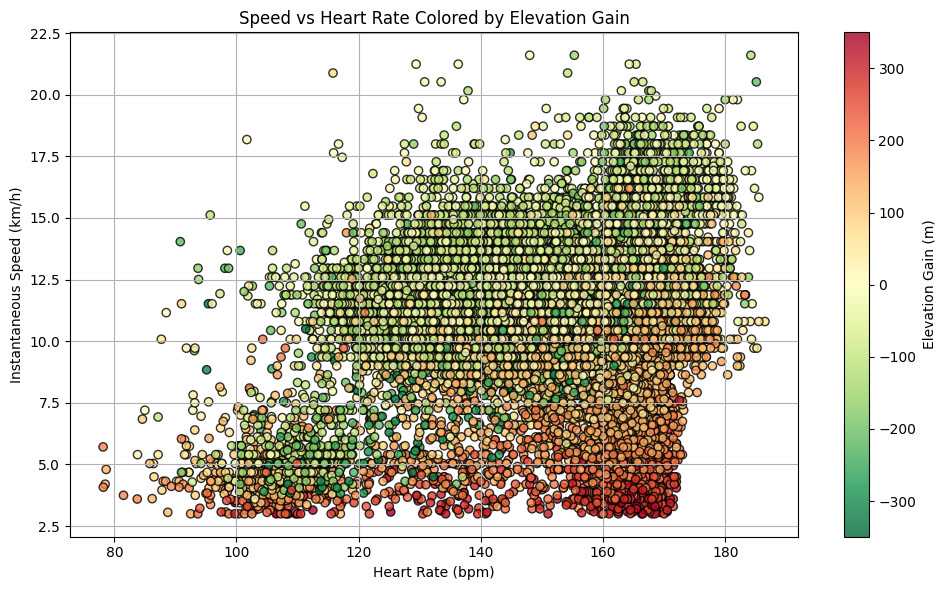

In [12]:
# Create the scatter plot
fig = plt.figure(figsize=(10, 6))
sc = plt.scatter(
    heartrate, 
    speed,
    c=elevation_gain,
    cmap='RdYlGn_r',
    edgecolor='k',
    alpha=0.8
)

# Add colorbar to show what elevation gain the colors represent
cbar = plt.colorbar(sc)
cbar.set_label('Elevation Gain (m)')

# Labels and title
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Speed vs Heart Rate Colored by Elevation Gain")
plt.grid(True)
plt.tight_layout()

if VERBOSE:
    fig.show()

# First GAP calibration method : Mimic Strava method

In [13]:
# Calculate normalized efficiencies
normalized_efficiencies = calculate_normalized_efficiency(
    speed, elevation_gain, heartrate
)

# Fit GAP model
efficiency_model = fit_gap_model(elevation_gain, normalized_efficiencies, min_samples_per_bucket=250)

<Figure size 1200x600 with 0 Axes>

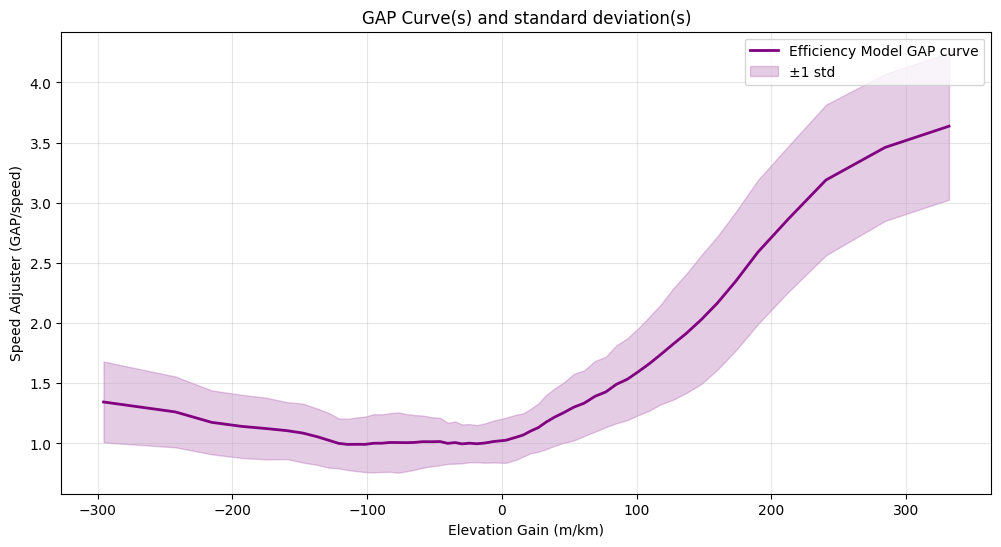

In [14]:
# Show resulting GAP curve
efficiency_model_gap_curve = get_efficiency_model_gap_curve(efficiency_model, smoothing_parameter=3)
efficiency_model_gap_curve['color'] = "purple"
fig = plot_gap_curves({'Efficiency Model': efficiency_model_gap_curve})

if VERBOSE:
    fig.show()

# Second GAP calibration method: XGBoost prediction model

In this section we will attempt a second method using a XGBoost prediction model.
The goal for this model will be to predict equivalent speed on flat surface (GAP) given real speed, elevation gain and heartrate. 

For this model to calibrate, we will need to build a training and testing dataset composed of:
- **X = [speed, elevation gain, heartrate]**
- **y = gap**

In order to build this dataset, we will create batches of data by matching datapoints where elevation gain is highly positive (or highly negative) to  ALL their 'close enough' points (in terms of heartrate) where elevation gain is close to 0.

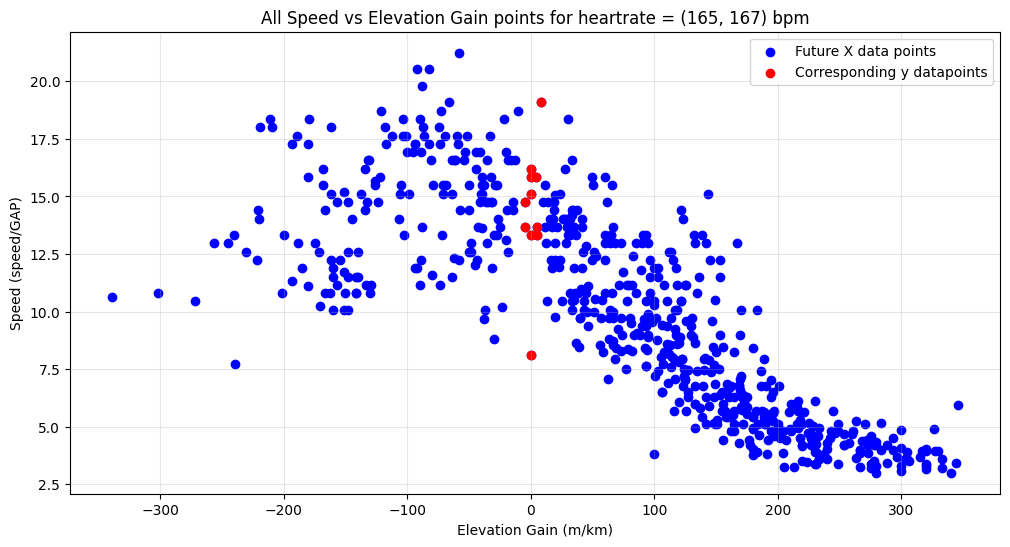

The heartrate range (165, 167) would result in 6809 data points for our model


In [15]:
# Here is a simple plot to visualize our idea

heartrate_range = (165, 167)
mask_heartrate = (heartrate >= heartrate_range[0]) * (heartrate <= heartrate_range[1])
mask_flat = (elevation_gain > -10) * (elevation_gain < 10)

fig = plt.figure(figsize=(12, 6))
plt.scatter(elevation_gain[mask_heartrate], speed[mask_heartrate], color='b', label='Future X data points')
plt.scatter(elevation_gain[mask_heartrate * mask_flat], speed[mask_heartrate * mask_flat], color='r', label='Corresponding y datapoints')

plt.xlabel('Elevation Gain (m/km)')
plt.ylabel('Speed (speed/GAP)')
plt.title(f'All Speed vs Elevation Gain points for heartrate = {heartrate_range} bpm')
plt.grid(True, alpha=0.3)
plt.legend()


if VERBOSE:
    plt.show()
    n_data_points_generated = sum(mask_heartrate) * sum(mask_heartrate * mask_flat)
    print(f"The heartrate range {heartrate_range} would result in {n_data_points_generated} data points for our model")

Using this quick visualization, we can estimate that using batches of heartrate range of 3, we should have around 5000 to 10000 data points per heartrate range. Let's now apply this to all our data.

In [16]:
# Create dataset
X, y = prepare_ml_calibration_dataset(
    speed, elevation_gain, heartrate, flat_elevation_gain_range=(-10, 10), hr_tolerance=3.0
)

# Train/test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the XGBoost model
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)

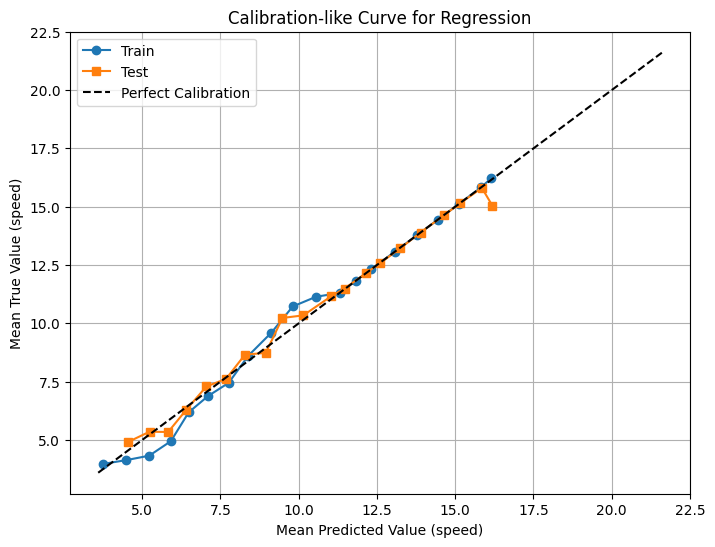

In [17]:
# Plot calibration curve
n_bins=20

bins = np.linspace(np.min(y_train_pred), np.max(y_train_pred), n_bins + 1)
bin_ids = np.digitize(y_train_pred, bins) - 1
train_bins = []
train_pred_bins = []
for i in range(n_bins):
    bin_mask = bin_ids == i
    if np.any(bin_mask):
        train_bins.append(np.mean(y_train[bin_mask]))
        train_pred_bins.append(np.mean(y_train_pred[bin_mask]))

bins = np.linspace(np.min(y_test_pred), np.max(y_test_pred), n_bins + 1)
bin_ids = np.digitize(y_test_pred, bins) - 1
test_bins = []
test_pred_bins = []
for i in range(n_bins):
    bin_mask = bin_ids == i
    if np.any(bin_mask):
        test_bins.append(np.mean(y_test[bin_mask]))
        test_pred_bins.append(np.mean(y_test_pred[bin_mask]))

fig = plt.figure(figsize=(8, 6))
plt.plot(train_pred_bins, train_bins, label='Train', marker='o')
plt.plot(test_pred_bins, test_bins, label='Test', marker='s')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Value (speed)')
plt.ylabel('Mean True Value (speed)')
plt.title('Calibration-like Curve for Regression')
plt.legend()
plt.grid(True)

if VERBOSE:
    plt.show()

The calibration curve shows no sign of overfitting as it follows the perfect calibration curve pretty well and looks close to the calibration curve for training data.

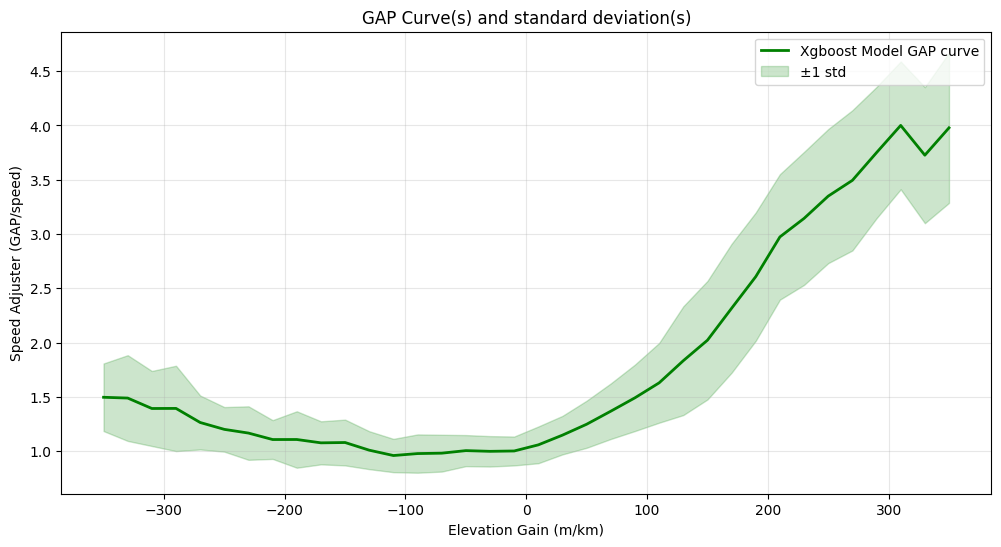

In [18]:
# Show resulting GAP curve
xgboost_model_gap_curve = get_xgboost_gap_curve(xgboost_model, X_test, bin_width=20)
xgboost_model_gap_curve['color'] = 'green'
fig = plot_gap_curves({'Xgboost Model': xgboost_model_gap_curve})

if VERBOSE:
    fig.show()

Because this second model explicitely uses heartrate as a feature, we can also plot a GAP curve by heartrate range. This enables to compare GAP curve depending on the athlete's intensity.

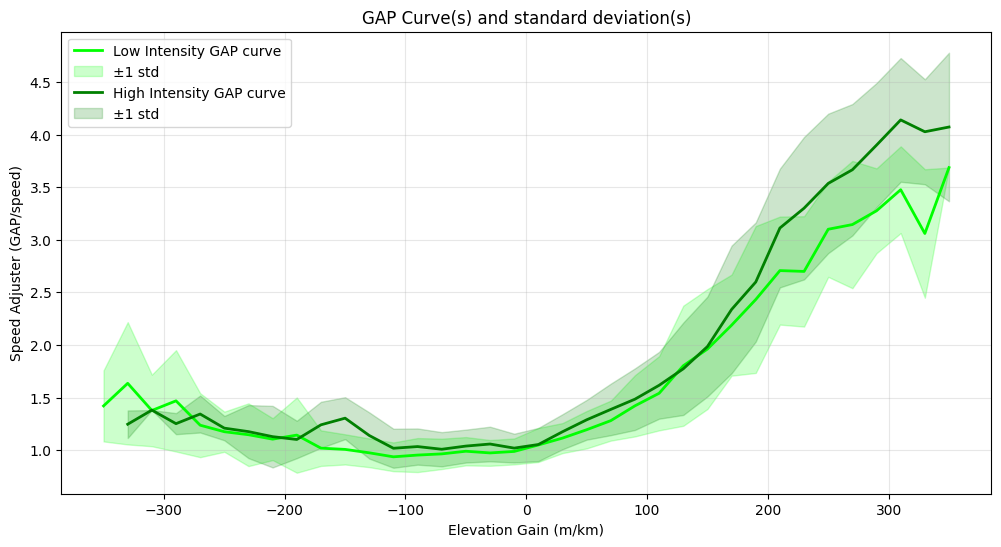

In [19]:
# Let's see if we can find differences between "high_intensity" GAP curve (160-190bpm) and "low_intensity" GAP curve (120-159bpm)
gap_curves = {}

gap_curves['Low Intensity'] = get_xgboost_gap_curve(
    xgboost_model, X_test, heartrate_range=(120, 150), bin_width=20
)
gap_curves['Low Intensity']['color'] = 'lime'

gap_curves['High Intensity'] = get_xgboost_gap_curve(
    xgboost_model, X_test, heartrate_range=(165, 190), bin_width=20
)
gap_curves['High Intensity']['color'] = 'green'

fig = plot_gap_curves(gap_curves)

if VERBOSE:
    fig.show()

- We can start to see a statistical difference between high and low intensities for high elevation gains. Indeed, for elevation gains above 200m per km, the GAP speed adjuster for high intensity efforts is higher.

- The explanation behind this could be that for high elevation gains, I walk at low intensities BUT run at high ones. To verify this effect we could for example add cadence as a model feature.

- **This also suggests that I am less effective in climbs at high intensity as compared to low intensities.**

# Comparing Models

The goal of this last part is to compare the models between one another, and also compore them to Strava's representative of the "average runner" (https://medium.com/strava-engineering/an-improved-gap-model-8b07ae8886c3) and Kilian Jornet's personnalized model (https://pickletech.eu/blog-gap/).

In [20]:
# Build Strava's average runner model
strava_model_gap_curve = {
    'bin_centers': np.array([-350, -300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350]),
    'means': np.array([1.7, 1.5, 1.3, 1.1, 0.9, 0.85, 0.9, 1, 1.2, 1.45, 1.8, 2.3, 2.75, 3.15, 3.55]),
    'stds': np.array([0] * 15),
    'counts': np.array([1] * 15),
    'color': 'red',
}

In [21]:
# Build Killian Jornet's model
killian_model_gap_curve = {
    'bin_centers': np.array([-350, -300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350]),
    'means': np.array([1.6, 1.35, 1.15, 1, 0.87, 0.85, 0.9, 1, 1.1, 1.3, 1.5, 1.7, 1.9, 2.15, 2.4]),
    'stds': np.array([0] * 15),
    'counts': np.array([1] * 15),
    'color': 'blue',
}

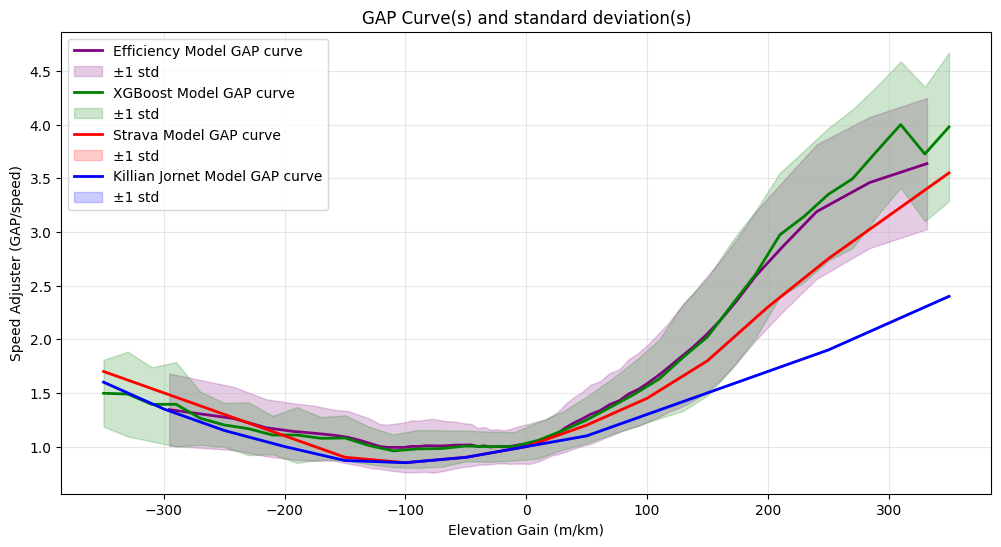

In [22]:
# plot all the curves together
gap_curves = {
    'Efficiency Model': efficiency_model_gap_curve,
    'XGBoost Model': xgboost_model_gap_curve,
    'Strava Model': strava_model_gap_curve,
    'Killian Jornet Model': killian_model_gap_curve
}
fig = plot_gap_curves(gap_curves)

if VERBOSE:
    fig.show()

### Main Takeaways:

- Both of my personnalized models are close. This suggests that combining speed and heartrate into efficiency does not lose much information.

- The Strava curve is entirely in the -/+ sigma range of my personnalized models, which suggests that the statistical difference is not evident. Nevertheless, we only used 61 activities for these plots, so it would be interesting to run these plots again when I will have more TrailRun activities.

- Nevertheless, the strava curve does seem to be under mine for high elevation gains. This suggests that I am a worst climber than average trail runners. On the other hand, my curve is under Strava's for downhills below 200m/km of elevation gain, which suggests that I am a better downhill runner than average. This is interesting because it is in line with what I believe to be my runner profile.

- Killian's curve is an interesting example of what we can achieve with a very trained athlete. We can clearly see that he is a much better climber than average (and me), but also a better downhill runner. For steep downhills nevertheless, we see that my profile converges towards his.

# Real life application 

In this last section I will show how the GAP models can be used to plot GAP over a full TrailRun activity. We will use the same activity as the one used in `notebook/gap/experimental.py`.

In [49]:
# Import activity
activity_stream = client.get_activity_streams(
    11943455818, 
    types=[
        "time",
        "distance",
        "altitude",
        "heartrate"
    ],
    resolution="low",
    series_type="time",
)

In [50]:
# Get speed, elevation gain and heartrate accross this full activity

# Process single stream
altitude = np.array(activity_stream['altitude'].data)[1:]
time, distance, speed, elevation_gain, heartrate = process_single_stream(activity_stream)

In [51]:
# Calculate gap using our 2 models
efficiency_model_gap = np.array(
    [calculate_efficiency_model_gap(s, eg, efficiency_model) for s, eg in zip(speed, elevation_gain)]
)
xgboost_model_gap = xgboost_model.predict(
    np.array([[s, eg, hr] for s, eg, hr in zip(speed, elevation_gain, heartrate)])
)

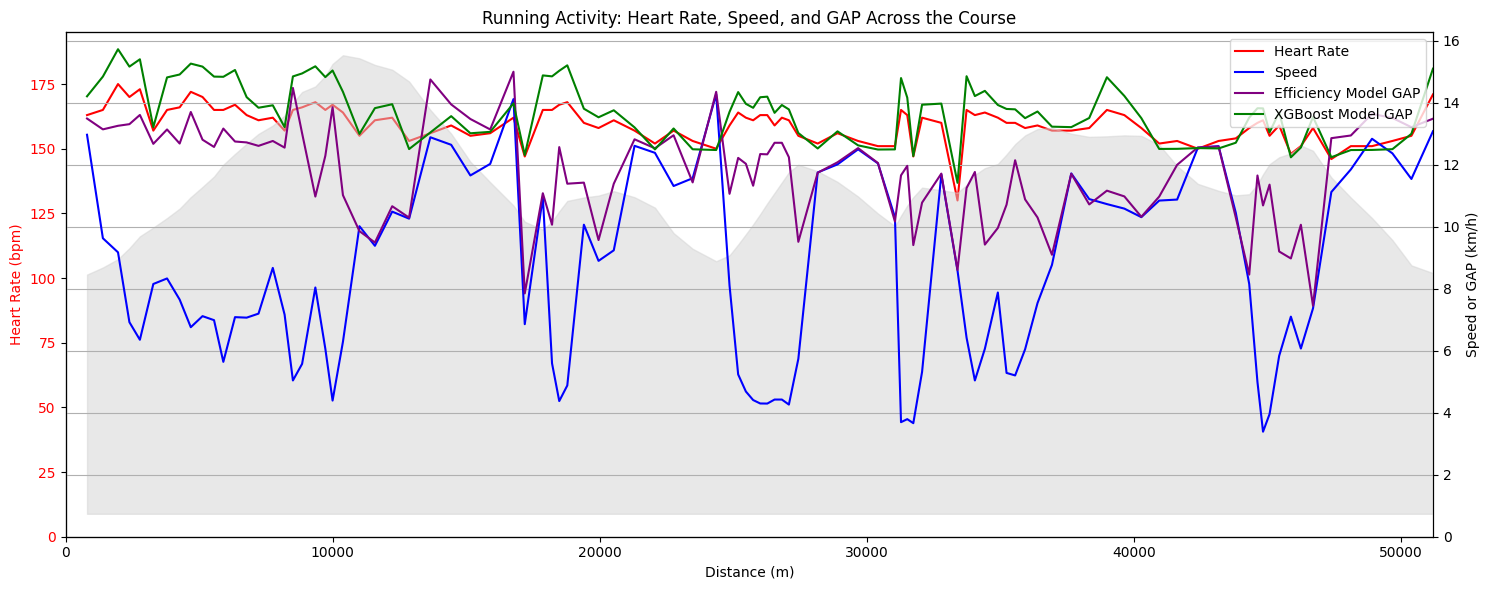

In [52]:
# Plot full activity
fig, ax1 = plt.subplots(figsize=(15, 6))

# --- Altitude as background fill (ax3, hidden) ---
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.spines['right'].set_visible(False)
ax3.tick_params(axis='y', colors='none')
ax3.set_yticklabels([])
ax3.fill_between(distance, altitude, color="lightgray", alpha=0.5, label='Altitude', zorder=1)

# --- Heart rate (ax1) ---
ax1.plot(distance, heartrate, color="red", label='Heart Rate', zorder=2)
ax1.set_xlim([0, distance[-1]])
ax1.set_ylim([0, np.max(heartrate) + 20])
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Heart Rate (bpm)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# --- Speed and GAP (ax2) ---
ax2 = ax1.twinx()
ax2.plot(distance, speed, color="blue", label='Speed')
ax2.plot(distance, efficiency_model_gap, color="purple", label="Efficiency Model GAP", linewidth=1.5)
ax2.plot(distance, xgboost_model_gap, color="green", label="XGBoost Model GAP", linewidth=1.5)

ax2.set_ylim([0, np.nanmax(speed) + 2])
ax2.set_ylabel('Speed or GAP (km/h)')

# --- Final touches ---
plt.title('Running Activity: Heart Rate, Speed, and GAP Across the Course')
fig.tight_layout()
plt.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

# END OF NOTEBOOK